# Project Title : Engine RUL Prediction
## Introduction
This project aims to predict the Remaining Useful Life (RUL) of aircraft engines based on time-series sensor data. By analyzing the degradation patterns captured by various sensors over time.

The dataset used for this project consists of time-series data collected from multiple engines. Each data point represents a single operational cycle for a specific engine, including various sensor readings and operational settings. The training data includes the complete operational history of engines up to failure, allowing us to calculate the true RUL. The test data contains partial operational histories, and the goal is to predict the RUL at the end of these partial sequences.

My approach will involve:

1. Data Loading and Preprocessing: Reading the data, handling missing or unnecessary columns, and preparing it for analysis.
2. Feature Engineering: Calculating the RUL and potentially creating new features from the raw sensor data.
3. Exploratory Data Analysis: Visualizing the data to understand RUL distribution, sensor behavior, and correlations.
4. Model Selection and Training: Training various regression models (Linear Regression, Random Forest, XGBoost, LightGBM, CatBoost) to predict RUL.
5. Evaluation and Comparison: Assessing model performance using metrics like MAE, RMSE, and R² and comparing the models.
6. prediction on unseen Test data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, matthews_corrcoef,
    confusion_matrix, roc_curve
)

## Loading and Labelling Dataset

In [159]:
train_df = pd.read_csv('train_FD001.txt', sep=' ', header=None)
test_df = pd.read_csv('test_FD001.txt', sep=' ', header=None)
rul_df = pd.read_csv('RUL_FD001.txt', sep=' ', header=None)

In [160]:
train_df.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]

In [161]:
test_df.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1   1   2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2   1   3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3   1   4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4   1   5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8125.55  8.4052  0.03  392  2388  100.0  38.86  23.3735 NaN NaN  
1  ...  8139.62  8.3803  0.03  393  2388  100.0  39.02  23.3916 NaN NaN  
2  ...  8130.10  8.4441  0.03  393  2388  100.0  39.08  23.4166 NaN NaN  
3  ...  8132.90  8.3917  0.03  391  2388  100.0  39.00  23.3737 NaN NaN  
4  ...  8129.54  8.4031  0.03  390  2388  100.0  38.99  23.4130 NaN NaN  

[5 rows x 28 columns]

In [162]:
rul_df.head()

0   1
0  112 NaN
1   98 NaN
2   69 NaN
3   82 NaN
4   91 NaN

In [163]:
print(f"Training dataset{train_df.shape}")
print(f"Training dataset{test_df.shape}")
print(f"True RUL dataset{rul_df.shape}")

Training dataset(20631, 28)
Training dataset(13096, 28)
True RUL dataset(100, 2)


In [164]:
print(f"Missing Values in training dataset:{train_df.isnull().sum().sum()}")
print(f"Missing Values in testing dataset:{test_df.isnull().sum().sum()}")
print(f"Missing Values in true RUL dataset:{rul_df.isnull().sum().sum()}")

Missing Values in training dataset:41262
Missing Values in testing dataset:26192
Missing Values in true RUL dataset:100


In [165]:
train_df=train_df.drop(columns=[26,27])
test_df=test_df.drop(columns=[26,27])
rul_df=rul_df.drop(columns=1)

In [166]:
print(f"Missing Values in training dataset:{train_df.isnull().sum().sum()}")
print(f"Missing Values in testing dataset:{test_df.isnull().sum().sum()}")
print(f"Missing Values in true RUL dataset:{rul_df.isnull().sum().sum()}")

Missing Values in training dataset:0
Missing Values in testing dataset:0
Missing Values in true RUL dataset:0


In [167]:
columns = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)] 
train_df.columns = columns
test_df.columns = columns

In [168]:
rul_df.columns = ["true_rul"]

## Defining RUL

In [169]:
def calculation_rul(df):
    df_rul = df.copy()
    max_cycles = df.groupby('engine_id')['cycle'].max().reset_index() 
    max_cycles.columns = ['engine_id', 'max_cycle']
    df_rul = df_rul.merge(max_cycles, on='engine_id') 
    df_rul['RUL'] = df_rul['max_cycle'] - df_rul['cycle']
    df_rul.drop(columns=['max_cycle'], inplace=True)

    return df_rul

In [170]:
train_df = calculation_rul(train_df)

## Exploring the Dataset

In [130]:
train_df.describe()

engine_id         cycle  op_setting_1  op_setting_2  op_setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000       20631.0   
mean      51.506568    108.807862     -0.000009      0.000002         100.0   
std       29.227633     68.880990      0.002187      0.000293           0.0   
min        1.000000      1.000000     -0.008700     -0.000600         100.0   
25%       26.000000     52.000000     -0.001500     -0.000200         100.0   
50%       52.000000    104.000000      0.000000      0.000000         100.0   
75%       77.000000    156.000000      0.001500      0.000300         100.0   
max      100.000000    362.000000      0.008700      0.000600         100.0   

       sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  ...  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01  ...   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15  ...   
min      518.67    641.210000   1571.040000   1382.250000  1.462000e+01  ...   
25%      518.67    642.325000   1586.260000   1402.360000  1.462000e+01  ...   
50%      518.67    642.640000   1590.100000   1408.040000  1.462000e+01  ...   
75%      518.67    643.000000   1594.380000   1414.555000  1.462000e+01  ...   
max      518.67    644.530000   1616.910000   1441.490000  1.462000e+01  ...   

          sensor_13     sensor_14     sensor_15     sensor_16     sensor_17  \
count  20631.000000  20631.000000  20631.000000  2.063100e+04  20631.000000   
mean    2388.096152   8143.752722      8.442146  3.000000e-02    393.210654   
std        0.071919     19.076176      0.037505  1.387812e-17      1.548763   
min     2387.880000   8099.940000      8.324900  3.000000e-02    388.000000   
25%     2388.040000   8133.245000      8.414900  3.000000e-02    392.000000   
50%     2388.090000   8140.540000      8.438900  3.000000e-02    393.000000   
75%     2388.140000   8148.310000      8.465600  3.000000e-02    394.000000   
max     2388.560000   8293.720000      8.584800  3.000000e-02    400.000000   

       sensor_18  sensor_19     sensor_20     sensor_21           RUL  
count    20631.0    20631.0  20631.000000  20631.000000  20631.000000  
mean      2388.0      100.0     38.816271     23.289705    107.807862  
std          0.0        0.0      0.180746      0.108251     68.880990  
min       2388.0      100.0     38.140000     22.894200      0.000000  
25%       2388.0      100.0     38.700000     23.221800     51.000000  
50%       2388.0      100.0     38.830000     23.297900    103.000000  
75%       2388.0      100.0     38.950000     23.366800    155.000000  
max       2388.0      100.0     39.430000     23.618400    361.000000  

[8 rows x 27 columns]

1. There is not any huge difference between the mean and median
2. No big difference between 3rd Quartile value and max value
<b> Both observations suggest that there are not any Huge outliers </b>

array([[<Axes: title={'center': 'op_setting_1'}>,
        <Axes: title={'center': 'op_setting_2'}>,
        <Axes: title={'center': 'op_setting_3'}>,
        <Axes: title={'center': 'sensor_1'}>,
        <Axes: title={'center': 'sensor_2'}>],
       [<Axes: title={'center': 'sensor_3'}>,
        <Axes: title={'center': 'sensor_4'}>,
        <Axes: title={'center': 'sensor_5'}>,
        <Axes: title={'center': 'sensor_6'}>,
        <Axes: title={'center': 'sensor_7'}>],
       [<Axes: title={'center': 'sensor_8'}>,
        <Axes: title={'center': 'sensor_9'}>,
        <Axes: title={'center': 'sensor_10'}>,
        <Axes: title={'center': 'sensor_11'}>,
        <Axes: title={'center': 'sensor_12'}>],
       [<Axes: title={'center': 'sensor_13'}>,
        <Axes: title={'center': 'sensor_14'}>,
        <Axes: title={'center': 'sensor_15'}>,
        <Axes: title={'center': 'sensor_16'}>,
        <Axes: title={'center': 'sensor_17'}>],
       [<Axes: title={'center': 'sensor_18'}>,
        <

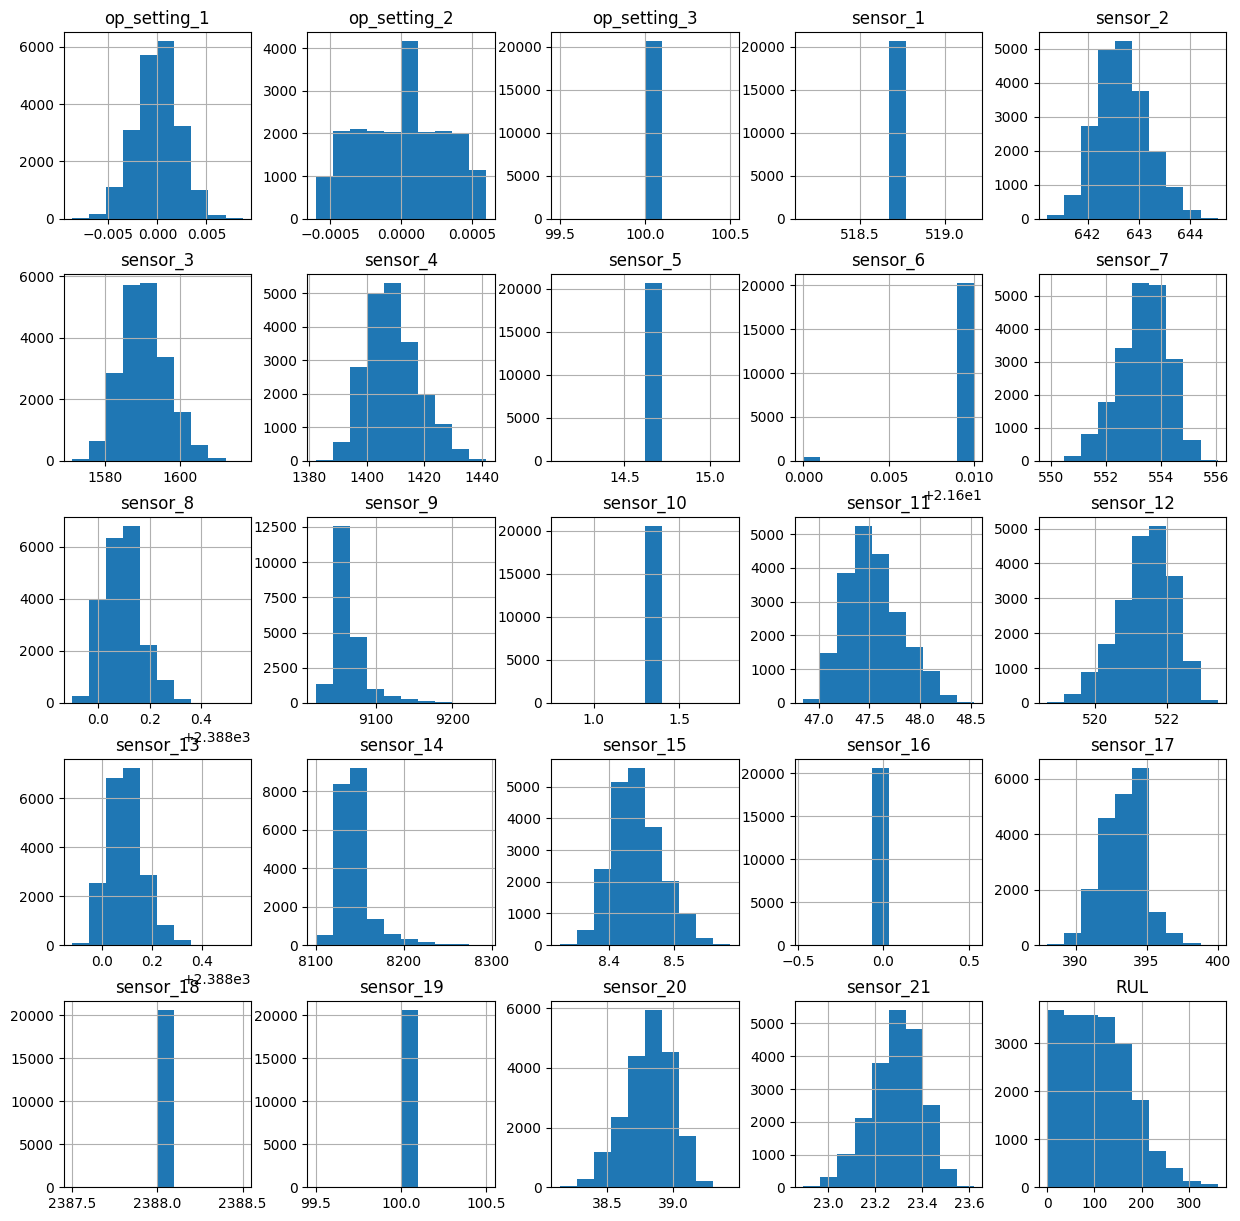

In [132]:
train_hist = train_df.drop(columns=['cycle','engine_id'],axis=1)
train_hist.hist(figsize=(15,15))

1. flat features are op_setting_3, sensor_5, sensor_10,18,19
2. Right-skewed distributions (outliers on the high end) sensor_6, sensor_8, sensor_13, sensor_18, sensor_19
3. RUL is slightly right-skewed


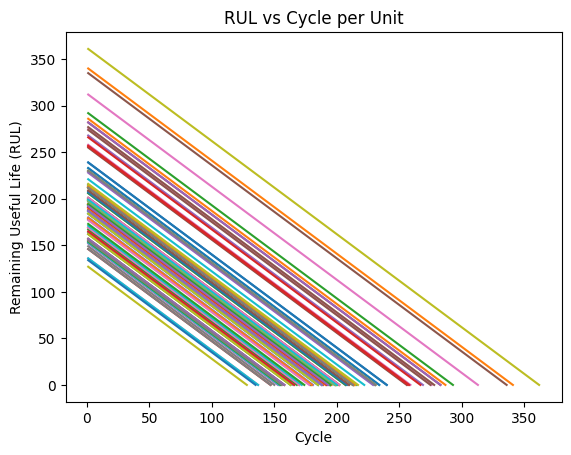

In [133]:
for engine in train_df['engine_id'].unique():
    engine_data = train_df[train_df['engine_id'] == engine]
    plt.plot(engine_data['cycle'], engine_data['RUL'])

plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("RUL vs Cycle per Unit")
plt.show()

1. the engine fails in the approximately from 125th cycle to 320th cycle 
2. the engine failiure is linear and consist of a consitant downward trend

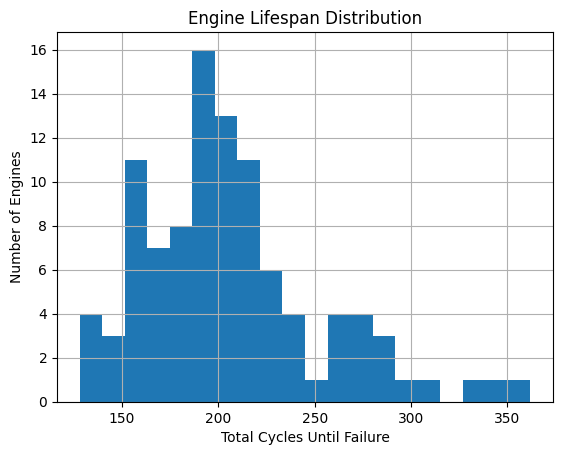

In [134]:
train_df.groupby('engine_id')['cycle'].max().hist(bins=20)
plt.xlabel('Total Cycles Until Failure')
plt.ylabel('Number of Engines')
plt.title('Engine Lifespan Distribution')
plt.show()

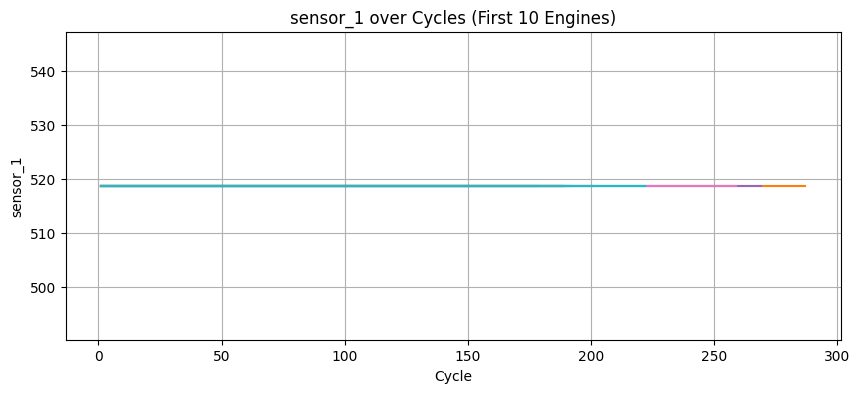

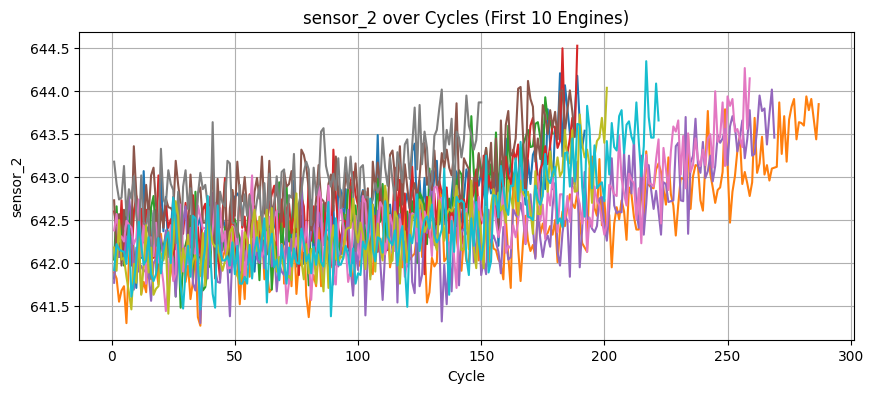

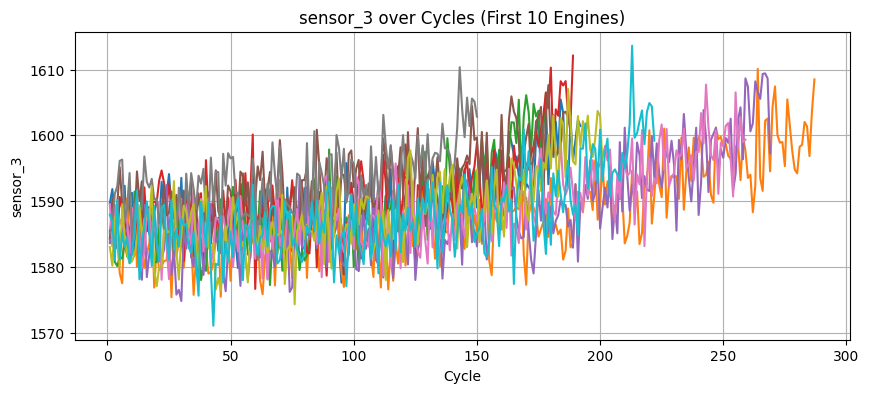

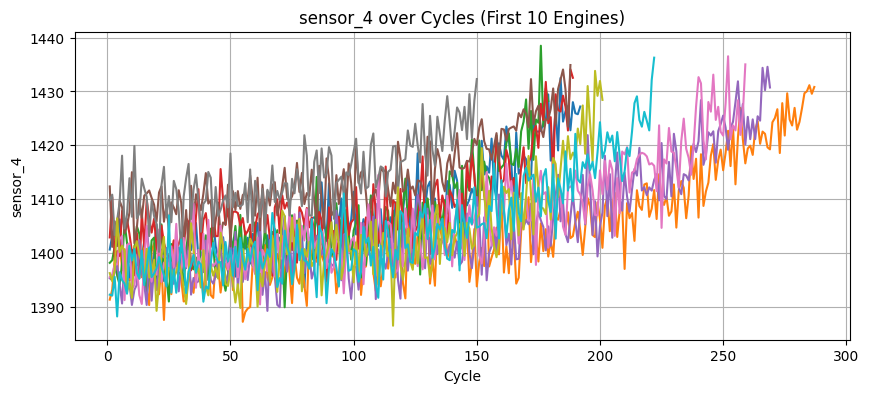

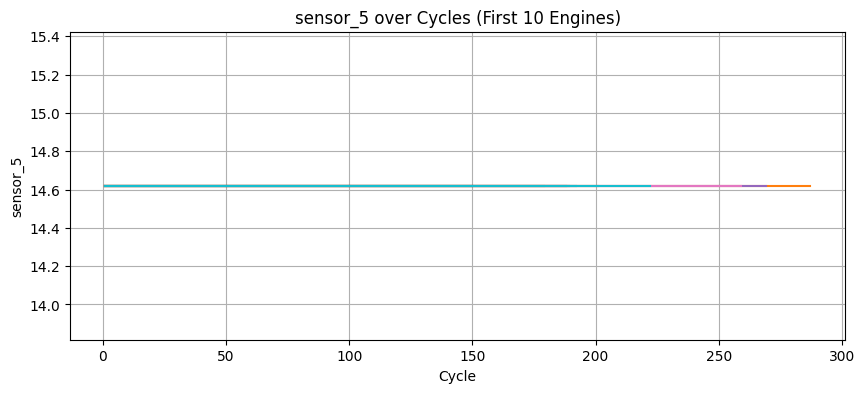

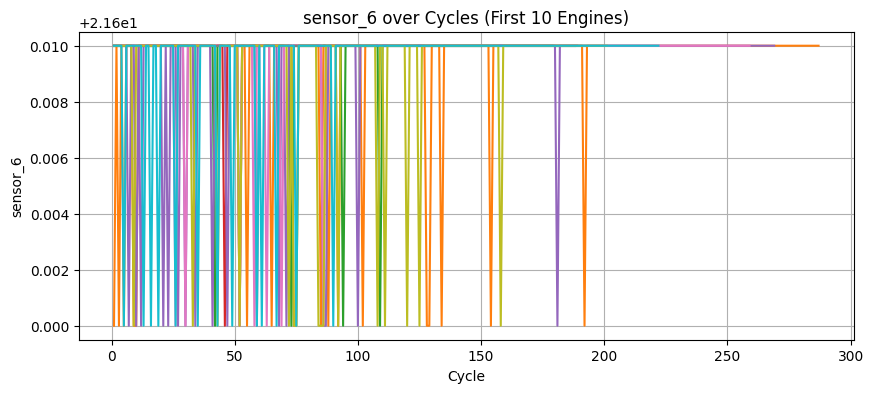

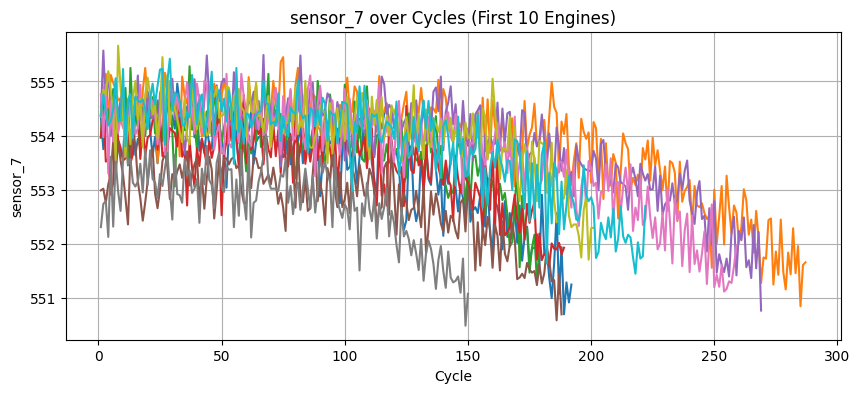

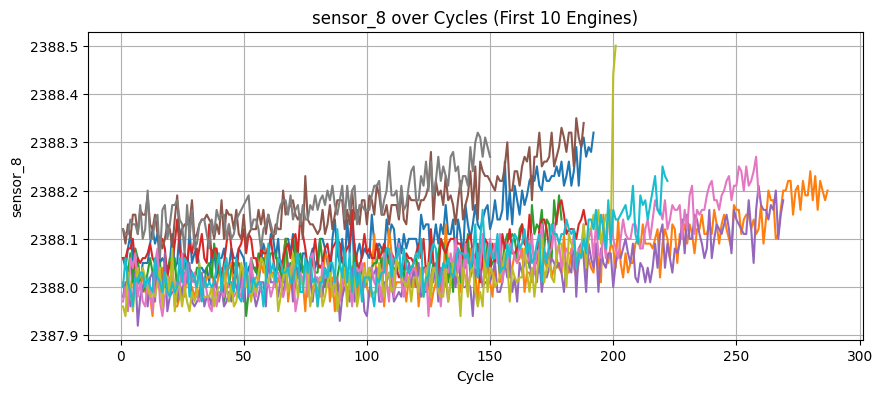

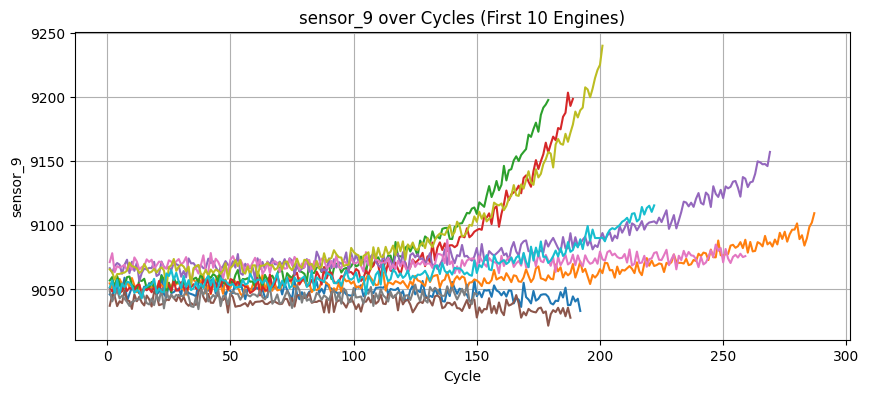

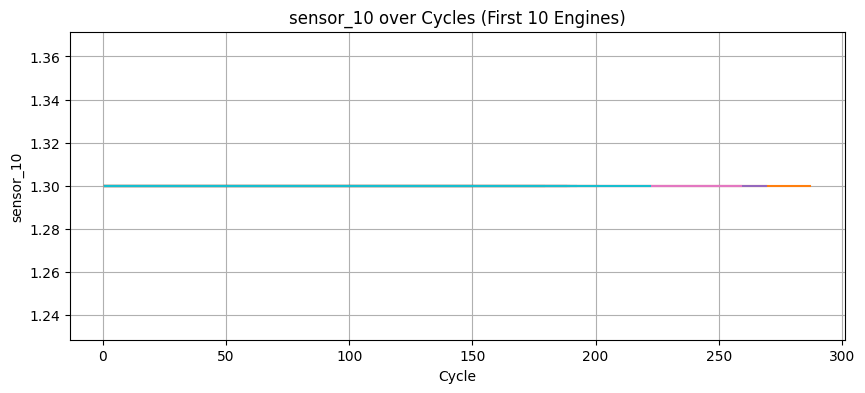

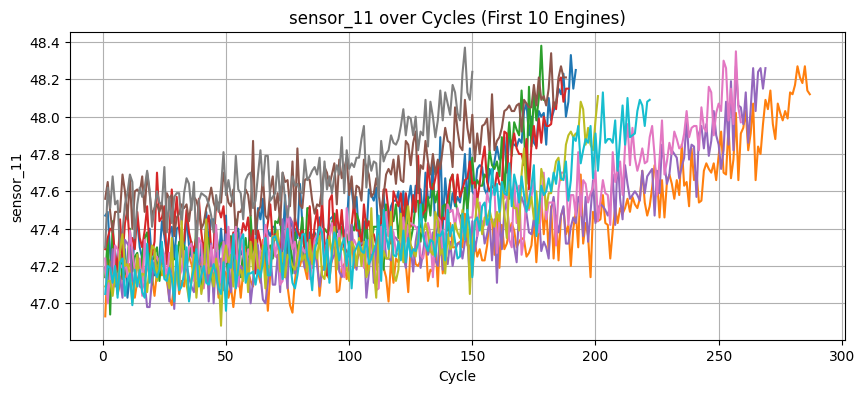

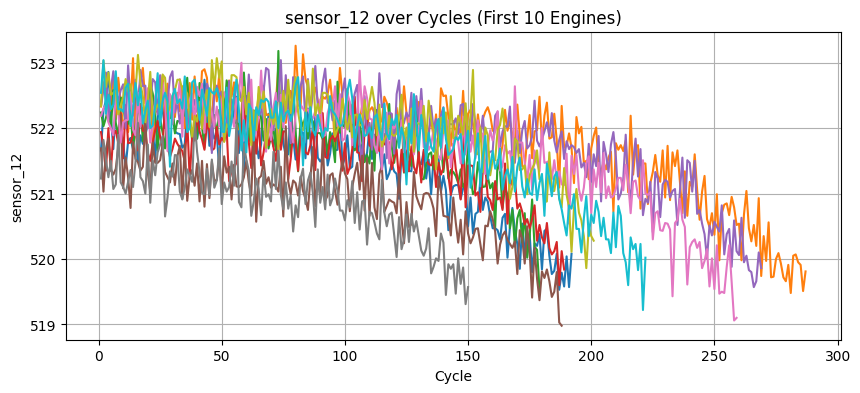

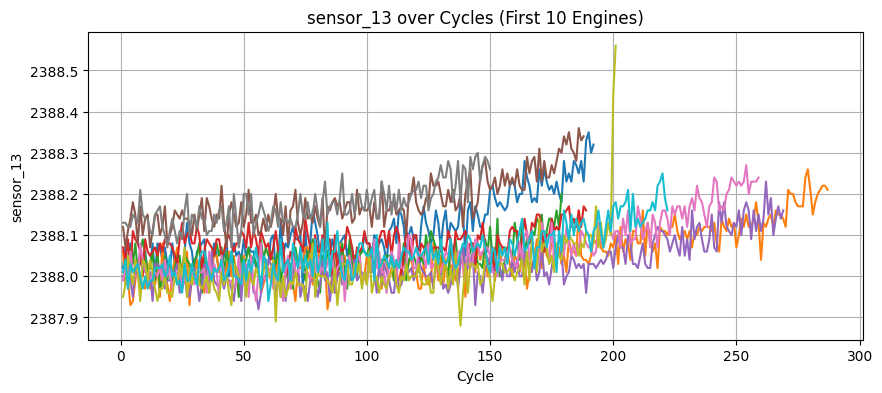

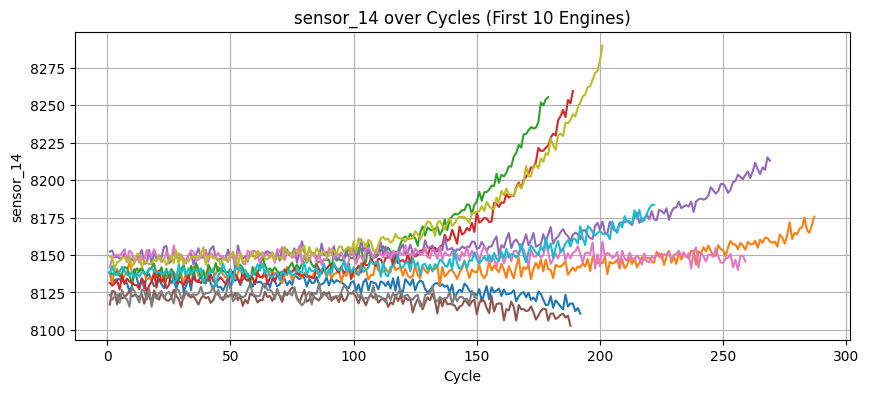

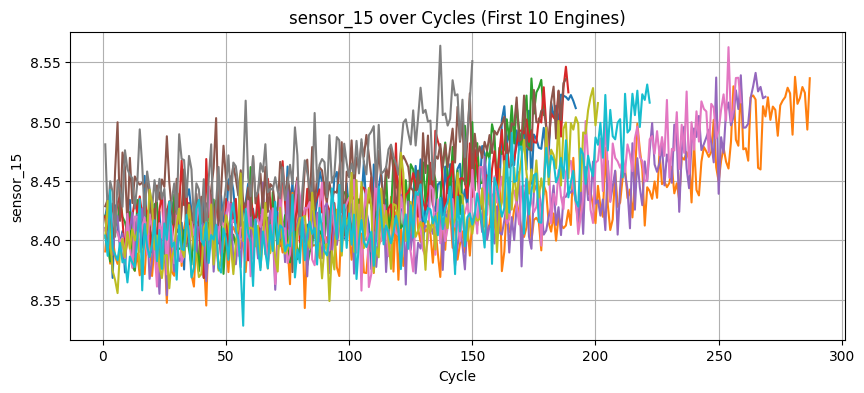

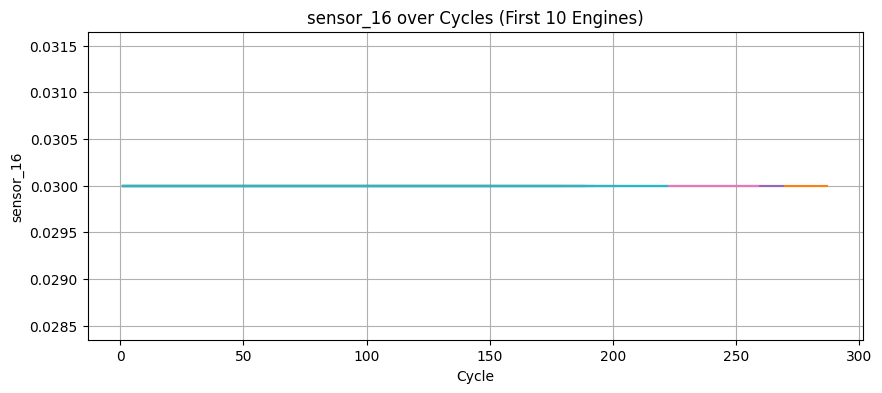

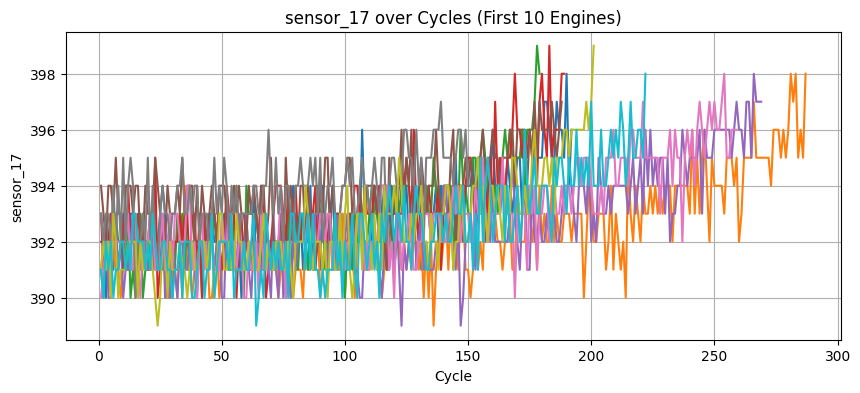

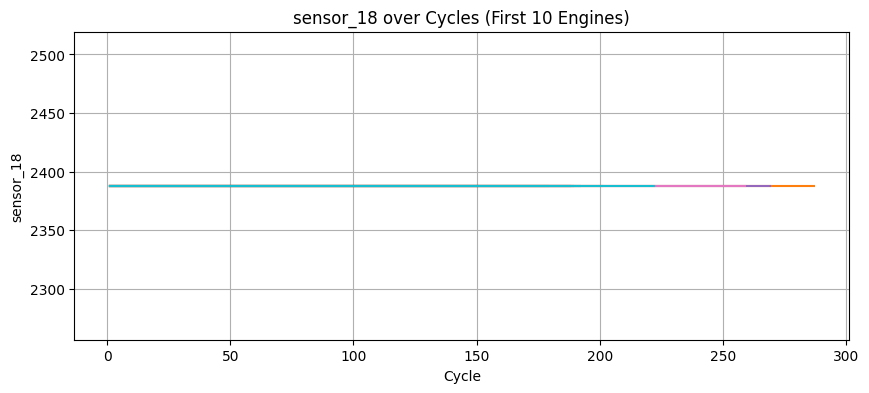

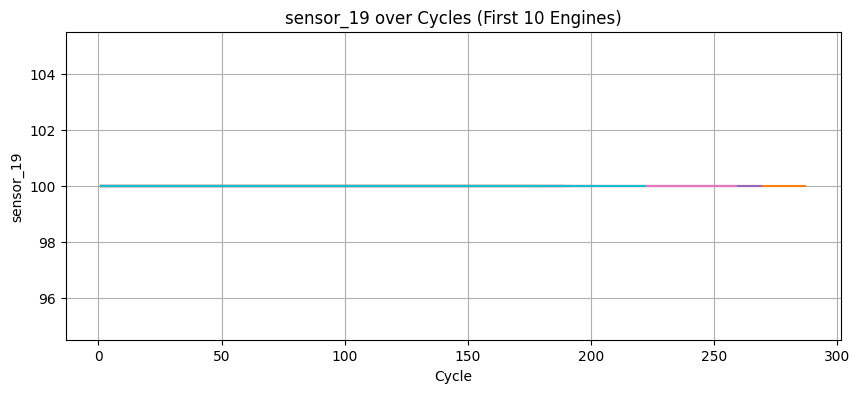

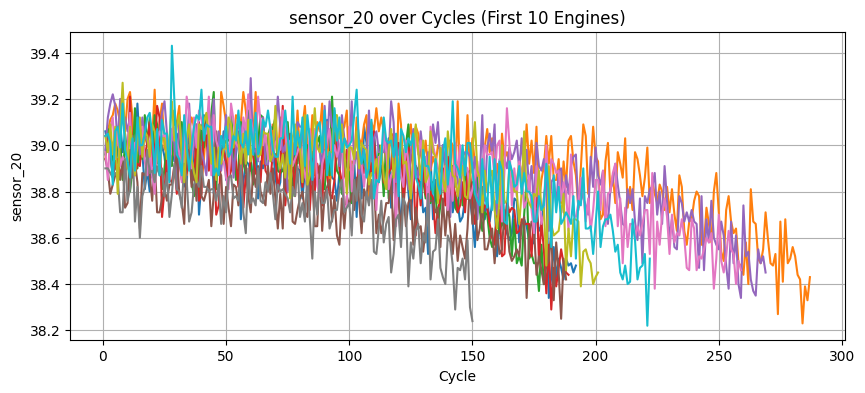

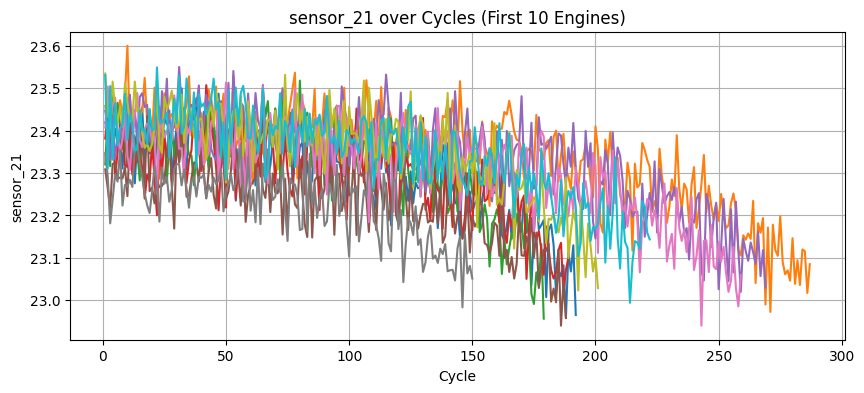

In [135]:
sensors = [col for col in train_df.columns if col.startswith('sensor')]

for sensor in sensors:
    plt.figure(figsize=(10, 4))
    for engine in train_df['engine_id'].unique()[:10]:  # Plot first 10 engines to avoid clutter
        engine_data = train_df[train_df['engine_id'] == engine]
        plt.plot(engine_data['cycle'], engine_data[sensor])
    plt.title(f"{sensor} over Cycles (First 10 Engines)")
    plt.xlabel("Cycle")
    plt.ylabel(sensor)
    plt.grid(True)
    plt.show()


In [136]:
print(train_df['sensor_6'].describe())
print(train_df['sensor_6'].nunique())


count    20631.000000
mean        21.609803
std          0.001389
min         21.600000
25%         21.610000
50%         21.610000
75%         21.610000
max         21.610000
Name: sensor_6, dtype: float64
2


<b> dropping : sensor -> 1,5,6,10,16,18,19 (flat and constant) </b>

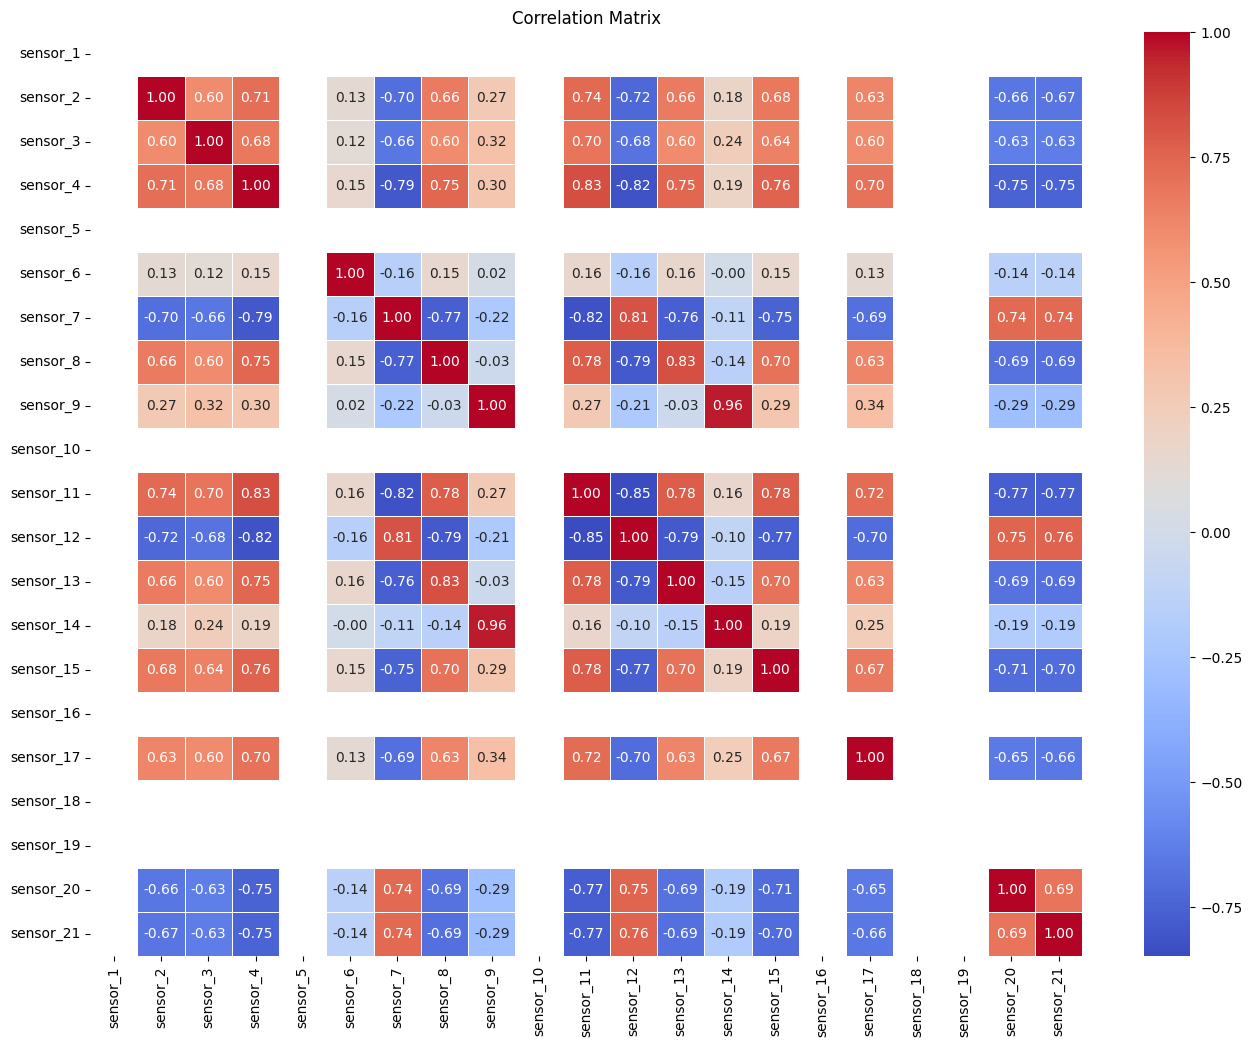

In [137]:
corr_matrix = train_df[sensors].corr()
plt.figure(figsize=(16, 12)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [22]:
sensor_stats = train_df[sensors].describe()

low_variance_sensors = []
for sensor in sensors:
    std_val = train_df[sensor].std()
    if std_val < 0.01:
        low_variance_sensors.append(sensor)
        print(f" {sensor}: std = {std_val:.6f} (LOW VARIANCE)")
    else:
        print(f" {sensor}: std = {std_val:.3f}")

 sensor_1: std = 0.000000 (LOW VARIANCE)
 sensor_2: std = 0.500
 sensor_3: std = 6.131
 sensor_4: std = 9.001
 sensor_5: std = 0.000000 (LOW VARIANCE)
 sensor_6: std = 0.001389 (LOW VARIANCE)
 sensor_7: std = 0.885
 sensor_8: std = 0.071
 sensor_9: std = 22.083
 sensor_10: std = 0.000000 (LOW VARIANCE)
 sensor_11: std = 0.267
 sensor_12: std = 0.738
 sensor_13: std = 0.072
 sensor_14: std = 19.076
 sensor_15: std = 0.038
 sensor_16: std = 0.000000 (LOW VARIANCE)
 sensor_17: std = 1.549
 sensor_18: std = 0.000000 (LOW VARIANCE)
 sensor_19: std = 0.000000 (LOW VARIANCE)
 sensor_20: std = 0.181
 sensor_21: std = 0.108


In [138]:
features_to_remove = ['op_setting_1', 'op_setting_2', 'op_setting_3']
features_to_remove.extend(low_variance_sensors)
train_clean = train_df.drop(features_to_remove, axis=1, errors='ignore')
test_clean = test_df.drop(features_to_remove, axis=1, errors='ignore')
print(f"Original features: {len(train_df.columns)}")
print(f"Remaining features: {len(train_clean.columns)}")

Original features: 27
Remaining features: 17


## Establishing a Baseline 

In [139]:
feature_columns = [ col for col in train_clean.columns
                   if col not in ['engine_id','cycle','RUL']]

X_train_full = train_clean[feature_columns]
y_train_full= train_clean['RUL']

X_train,X_val,y_train,y_val = train_test_split(
    X_train_full,y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=None
)
def evaluate_model(y_true,y_pred,model_name):
    mae = mean_absolute_error(y_true,y_pred)
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    r2=r2_score(y_true,y_pred)
  

    print(f"\n=== {model_name} PERFORMANCE ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")
   
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, }

In [140]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred_train = lr_model.predict(X_train)
lr_pred_val = lr_model.predict(X_val)


lr_train_metrics = evaluate_model(y_train, lr_pred_train, "Linear Regression (Training)")
lr_val_metrics = evaluate_model(y_val, lr_pred_val, "Linear Regression (Validation)")


=== Linear Regression (Training) PERFORMANCE ===
MAE:  34.161
RMSE: 44.762
R²:   0.582

=== Linear Regression (Validation) PERFORMANCE ===
MAE:  34.051
RMSE: 44.334
R²:   0.570


In [141]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=10
)
rf_model.fit(X_train, y_train)

rf_pred_train = rf_model.predict(X_train)
rf_pred_val = rf_model.predict(X_val)

rf_train_metrics = evaluate_model(y_train, rf_pred_train, "Random Forest (Training)")
rf_val_metrics = evaluate_model(y_val, rf_pred_val, "Random Forest (Validation)")


=== Random Forest (Training) PERFORMANCE ===
MAE:  24.875
RMSE: 35.576
R²:   0.736

=== Random Forest (Validation) PERFORMANCE ===
MAE:  29.345
RMSE: 41.121
R²:   0.630


In [142]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)


xgb_model.fit(X_train, y_train)
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_val = xgb_model.predict(X_val)

xgb_train_metrics = evaluate_model(y_train, xgb_pred_train, "XGBoost (Training)")
xgb_val_metrics = evaluate_model(y_val, xgb_pred_val, "XGBoost (Validation)")



=== XGBoost (Training) PERFORMANCE ===
MAE:  24.580
RMSE: 34.919
R²:   0.745

=== XGBoost (Validation) PERFORMANCE ===
MAE:  29.755
RMSE: 41.541
R²:   0.622


In [28]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_val,label=y_val, reference=train_data)

lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)
lgb_model.fit(X_train, y_train)
lgb_pred_train = lgb_model.predict(X_train)
lgb_pred_val = lgb_model.predict(X_val)

lgb_train_metrics = evaluate_model(y_train, lgb_pred_train, "LightGBM (Training)")
lgb_val_metrics = evaluate_model(y_val, lgb_pred_val, "LightGBM (Validation)")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 16
[LightGBM] [Info] Start training from score 107.559683

=== LightGBM (Training) PERFORMANCE ===
MAE:  16.414
RMSE: 23.015
R²:   0.889

=== LightGBM (Validation) PERFORMANCE ===
MAE:  30.434
RMSE: 42.664
R²:   0.602


In [29]:
from catboost import CatBoostRegressor
import numpy as np

cat_model = CatBoostRegressor(
    iterations=100,           
    learning_rate=0.1,
    depth=6,                
    random_seed=42,
    verbose=0,
    thread_count=-1
)
cat_model.fit(X_train, y_train)
cat_pred_train= cat_model.predict(X_train)
cat_pred_val = cat_model.predict(X_val)
cat_train_metrics = evaluate_model(y_train, cat_pred_train, "CatBoost (Training)")
cat_val_metrics = evaluate_model(y_val, cat_pred_val, "CatBoost (Validation)")


=== CatBoost (Training) PERFORMANCE ===
MAE:  28.412
RMSE: 40.032
R²:   0.665

=== CatBoost (Validation) PERFORMANCE ===
MAE:  29.599
RMSE: 41.133
R²:   0.630


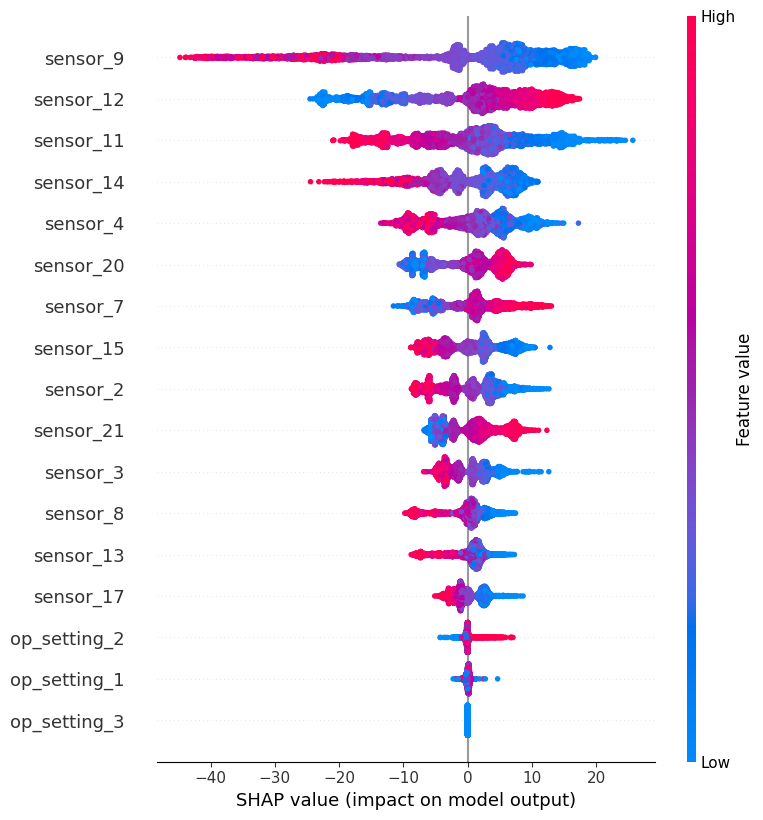

In [30]:
import shap
shap.initjs()

explainer = shap.Explainer(cat_model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)
shap.plots.force(shap_values[0])

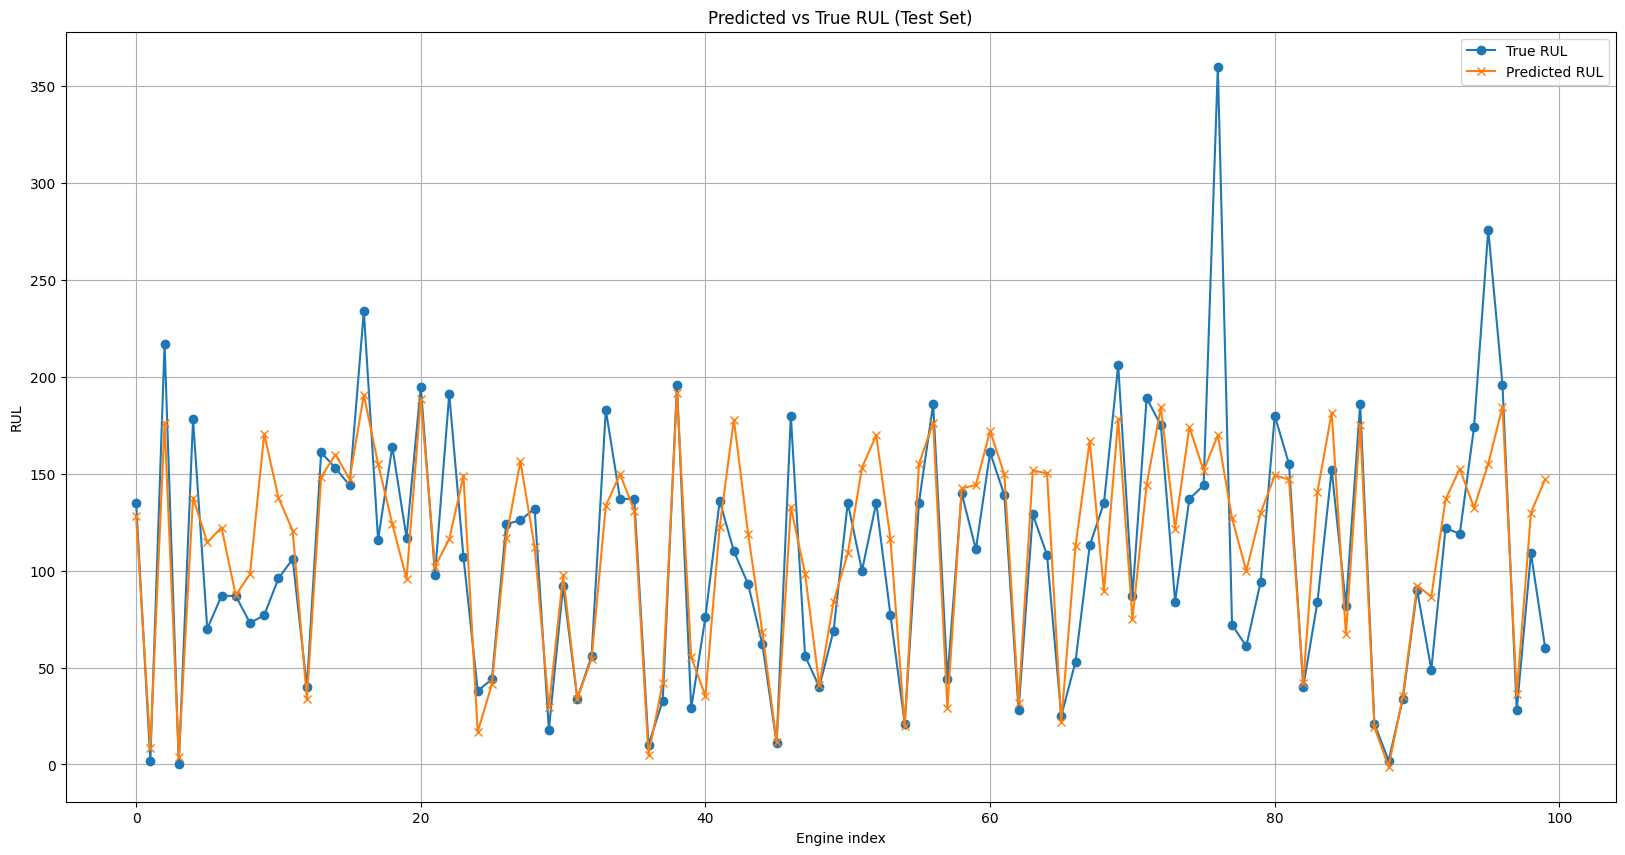

In [175]:

plt.figure(figsize=(20,10))
plt.plot(y_val.values[:100], label="True RUL", marker='o')
plt.plot(cat_pred_val[:100], label="Predicted RUL", marker='x')
plt.xlabel("Engine index")
plt.ylabel("RUL")
plt.legend()
plt.title("Predicted vs True RUL (Test Set)")
plt.grid(True)
plt.show()



In [32]:
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM','CatBoost'],
    'Validation MAE': [lr_val_metrics['MAE'], rf_val_metrics['MAE'], xgb_val_metrics['MAE'],lgb_val_metrics['MAE'],cat_val_metrics['MAE']],
    'Validation RMSE': [lr_val_metrics['RMSE'], rf_val_metrics['RMSE'], xgb_val_metrics['RMSE'],lgb_val_metrics['RMSE'],cat_val_metrics['RMSE']],
    'Validation R²': [lr_val_metrics['R2'], rf_val_metrics['R2'], xgb_val_metrics['R2'],lgb_val_metrics['R2'],cat_val_metrics['R2']]
}

comparison_df = pd.DataFrame(comparison_data)
print("=== MODEL COMPARISON (VALIDATION SET) ===")
print(comparison_df.to_string(index=False, float_format='%.3f'))

# Find best model
best_idx = comparison_df['Validation RMSE'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_rmse = comparison_df.loc[best_idx, 'Validation RMSE']

print(f"\n BEST MODEL: {best_model_name}")
print(f" Best RMSE: {best_rmse:.3f}")

=== MODEL COMPARISON (VALIDATION SET) ===
            Model  Validation MAE  Validation RMSE  Validation R²
Linear Regression          34.065           44.353          0.569
    Random Forest          29.382           41.144          0.629
          XGBoost          29.702           41.566          0.622
         LightGBM          30.434           42.664          0.602
         CatBoost          29.599           41.133          0.630

 BEST MODEL: CatBoost
 Best RMSE: 41.133


<b> The baseline we need to improve on 0.630 </b>

# Feature Engineering

In [33]:
def clip_rul(df, max_rul=130):
    df['RUL'] = df['RUL'].apply(lambda x: min(x, max_rul))
    return df
clip_rul(train_clean)
print("Clipped values:", sum(train_clean['RUL'] == 130))

Clipped values: 7633


In [34]:
window = 5 
grouped = train_clean.groupby('engine_id')

for col in feature_columns:
    train_clean[f"{col}_rolling_mean"] =grouped[col].rolling(window).mean().reset_index(0, drop=True)
    train_clean[f"{col}_rolling_std"] = grouped[col].rolling(window).std().reset_index(0, drop=True)
    train_clean[f'{col}_rolling_min'] = grouped[col].rolling(window).min().reset_index(0, drop=True)
    train_clean[f'{col}_rolling_max'] = grouped[col].rolling(window).max().reset_index(0, drop=True)
    train_clean[f'{col}_rolling_range'] = ( grouped[col].rolling(window).agg(lambda x: x.max() - x.min()).reset_index(0, drop=True))

In [35]:
train_clean.head()

engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_2  \
0          1      1       -0.0007       -0.0004         100.0    641.82   
1          1      2        0.0019       -0.0003         100.0    642.15   
2          1      3       -0.0043        0.0003         100.0    642.35   
3          1      4        0.0007        0.0000         100.0    642.35   
4          1      5       -0.0019       -0.0002         100.0    642.37   

   sensor_3  sensor_4  sensor_7  sensor_8  ...  sensor_20_rolling_mean  \
0   1589.70   1400.60    554.36   2388.06  ...                     NaN   
1   1591.82   1403.14    553.75   2388.04  ...                     NaN   
2   1587.99   1404.20    554.26   2388.08  ...                     NaN   
3   1582.79   1401.87    554.45   2388.11  ...                     NaN   
4   1582.85   1406.22    554.00   2388.06  ...                  38.958   

   sensor_20_rolling_std  sensor_20_rolling_min  sensor_20_rolling_max  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4               0.073621                  38.88                  39.06   

   sensor_20_rolling_range  sensor_21_rolling_mean  sensor_21_rolling_std  \
0                      NaN                     NaN                    NaN   
1                      NaN                     NaN                    NaN   
2                      NaN                     NaN                    NaN   
3                      NaN                     NaN                    NaN   
4                     0.18                23.39302               0.033498   

   sensor_21_rolling_min  sensor_21_rolling_max  sensor_21_rolling_range  
0                    NaN                    NaN                      NaN  
1                    NaN                    NaN                      NaN  
2                    NaN                    NaN                      NaN  
3                    NaN                    NaN                      NaN  
4                23.3442                23.4236                   0.0794  

[5 rows x 105 columns]

In [36]:
train_clean.fillna(method='bfill', inplace=True)  # or .fillna(0) if appropriate

C:\Users\JONNA RISHIKA ANANYA\AppData\Local\Temp\ipykernel_844\3153314469.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_clean.fillna(method='bfill', inplace=True)  # or .fillna(0) if appropriate


In [38]:
feature_columns1 = [col for col in train_clean.columns if col.startswith('sensor')]


In [39]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

X_train_full1 = train_clean[feature_columns1]
y_train_full1= train_clean['RUL']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full1, y_train_full1,
    test_size=0.2,
    random_state=42
)

cat_model1 = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
    thread_count=-1
)

cat_model1.fit(X_train, y_train)

cat_pred_train1 = cat_model1.predict(X_train)
cat_pred_val1 = cat_model1.predict(X_val)

cat_train_metrics1 = evaluate_model(y_train, cat_pred_train1, "CatBoost (Training - with new features)")
cat_val_metrics1 = evaluate_model(y_val, cat_pred_val1, "CatBoost (Validation - with new features)")



=== CatBoost (Training - with new features) PERFORMANCE ===
MAE:  12.442
RMSE: 16.961
R²:   0.848

=== CatBoost (Validation - with new features) PERFORMANCE ===
MAE:  13.100
RMSE: 18.055
R²:   0.823


<b> the R<sup>2</sup> increased by 0.193 yay </b>

<Axes: >

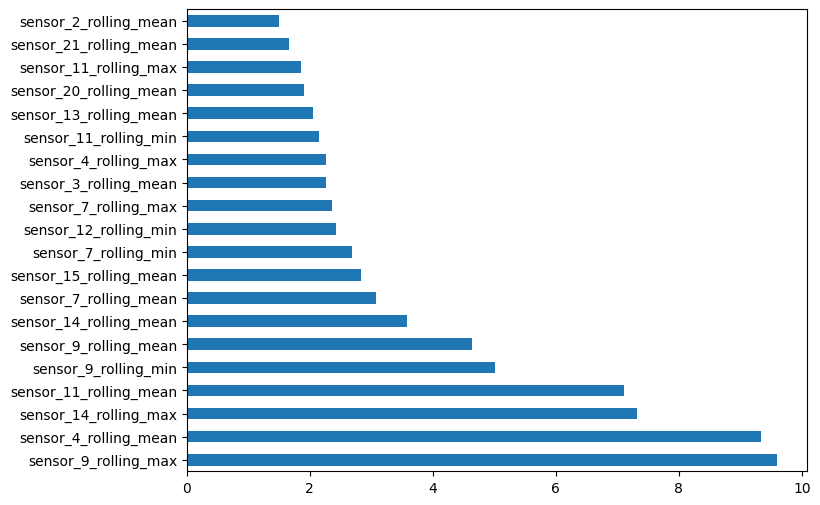

In [40]:
feature_importances = pd.Series(cat_model1.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(8,6))


In [41]:
train_clean2 = train_clean.copy()
grouped = train_clean2.groupby('engine_id')

lagged_features = []

for col in feature_columns1:
    for lag in [1, 2, 3]:
        lag_col_name = f'{col}_lag_{lag}'
        lagged_col = grouped[col].shift(lag)
        lagged_col.name = lag_col_name
        lagged_features.append(lagged_col)

lagged_df = pd.concat(lagged_features, axis=1)
train_clean2 = pd.concat([train_clean2, lagged_df], axis=1)
    

In [42]:
columns_to_remove = {'engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3','RUL'}
feature_columns2 = [col for col in train_clean2.columns if col not in columns_to_remove]


In [43]:

X_train_full2 = train_clean2[feature_columns2]
y_train_full2= train_clean2['RUL']

X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train_full2, y_train_full2,
    test_size=0.2,
    random_state=42
)

cat_model2 = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
    thread_count=-1
)

cat_model2.fit(X_train2, y_train2)

cat_pred_train2 = cat_model2.predict(X_train2)
cat_pred_val2= cat_model2.predict(X_val2)

cat_train_metrics2= evaluate_model(y_train2, cat_pred_train2, "CatBoost (Training - with new features)")
cat_val_metrics2 = evaluate_model(y_val2, cat_pred_val2, "CatBoost (Validation - with new features)")



=== CatBoost (Training - with new features) PERFORMANCE ===
MAE:  12.325
RMSE: 16.799
R²:   0.851

=== CatBoost (Validation - with new features) PERFORMANCE ===
MAE:  13.067
RMSE: 17.988
R²:   0.825


the R<sup>2</sup> has increased 0.02 the magnitude of the error has decreased  by 0.067 

In [ ]:
def calculate_slope(series):
    x = np.arange(len(series))
    if len(series.dropna()) < 2:
        return 0
    slope = np.polyfit(x, series, 1)[0]
    return slope

new_slope_features = {}

for col in feature_columns1:  
    slope_series = grouped[col].rolling(window).apply(calculate_slope, raw=False).reset_index(0, drop=True)
    new_slope_features[f'{col}_slope'] = slope_series

slope_df = pd.DataFrame(new_slope_features)
train_clean3 = pd.concat([train_clean3.reset_index(drop=True), slope_df], axis=1)


In [186]:
feature_columns3 = [col for col in train_clean3.columns if col not in columns_to_remove]

In [189]:

X_train_full3 = train_clean3[feature_columns3]
y_train_full3= train_clean3['RUL']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full2, y_train_full2,
    test_size=0.2,
    random_state=42
)

cat_model3 = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
    thread_count=-1
)

cat_model3.fit(X_train, y_train)

cat_pred_train3 = cat_model3.predict(X_train)
cat_pred_val3= cat_model3.predict(X_val)

cat_train_metrics3= evaluate_model(y_train, cat_pred_train3, "CatBoost (Training - with new features)")
cat_val_metrics3= evaluate_model(y_val, cat_pred_val3, "CatBoost (Validation - with new features)")


=== CatBoost (Training - with new features) PERFORMANCE ===
MAE:  12.325
RMSE: 16.799
R²:   0.851

=== CatBoost (Validation - with new features) PERFORMANCE ===
MAE:  13.067
RMSE: 17.988
R²:   0.825


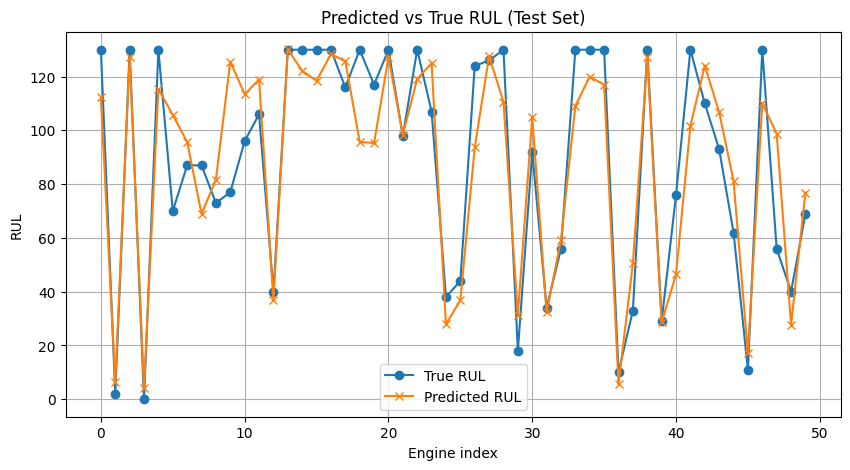

In [77]:

plt.figure(figsize=(10,5))
plt.plot(y_val2.values[:50], label="True RUL", marker='o')
plt.plot(cat_pred_val2[:50], label="Predicted RUL", marker='x')
plt.xlabel("Engine index")
plt.ylabel("RUL")
plt.legend()
plt.title("Predicted vs True RUL (Test Set)")
plt.grid(True)
plt.show()

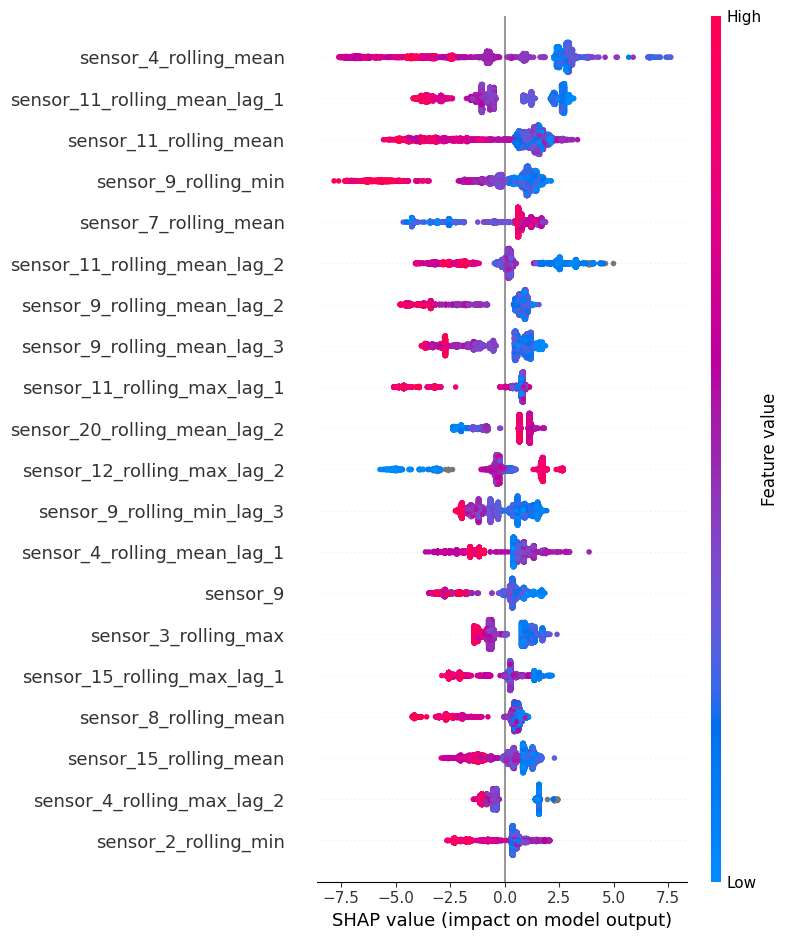

In [79]:
explainer = shap.Explainer(cat_model2)
shap_values = explainer(X_val2)
shap.summary_plot(shap_values, X_val2)
shap.plots.force(shap_values[0])

# Testing on Unseen Data

In [143]:
test_clean.head()

engine_id  cycle  sensor_2  sensor_3  sensor_4  sensor_7  sensor_8  \
0          1      1    643.02   1585.29   1398.21    553.90   2388.04   
1          1      2    641.71   1588.45   1395.42    554.85   2388.01   
2          1      3    642.46   1586.94   1401.34    554.11   2388.05   
3          1      4    642.44   1584.12   1406.42    554.07   2388.03   
4          1      5    642.51   1587.19   1401.92    554.16   2388.01   

   sensor_9  sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  sensor_17  \
0   9050.17      47.20     521.72    2388.03    8125.55     8.4052        392   
1   9054.42      47.50     522.16    2388.06    8139.62     8.3803        393   
2   9056.96      47.50     521.97    2388.03    8130.10     8.4441        393   
3   9045.29      47.28     521.38    2388.05    8132.90     8.3917        391   
4   9044.55      47.31     522.15    2388.03    8129.54     8.4031        390   

   sensor_20  sensor_21  
0      38.86    23.3735  
1      39.02    23.3916  
2      39.08    23.4166  
3      39.00    23.3737  
4      38.99    23.4130

need to remove engine id, (we have to group it by engine id) and remove cycle, we need to add both rolling statistic and lag features.
drop low variance sensors 

In [46]:
rul_df.head()

true_rul
0       112
1        98
2        69
3        82
4        91

In [145]:
grouped_test = test_clean.groupby('engine_id')

for col in feature_columns:
    test_clean[f"{col}_rolling_mean"] =grouped_test[col].rolling(window).mean().reset_index(0, drop=True)
    test_clean[f"{col}_rolling_std"] = grouped_test[col].rolling(window).std().reset_index(0, drop=True)
    test_clean[f'{col}_rolling_min'] = grouped_test[col].rolling(window).min().reset_index(0, drop=True)
    test_clean[f'{col}_rolling_max'] = grouped_test[col].rolling(window).max().reset_index(0, drop=True)
    test_clean[f'{col}_rolling_range'] = ( grouped_test[col].rolling(window).agg(lambda x: x.max() - x.min()).reset_index(0, drop=True))

In [146]:
test_clean.fillna(method='bfill', inplace=True) 

C:\Users\JONNA RISHIKA ANANYA\AppData\Local\Temp\ipykernel_844\2839658045.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_clean.fillna(method='bfill', inplace=True)


In [147]:
feature_columns1 = [col for col in test_clean.columns if col.startswith('sensor')]
grouped = test_clean.groupby('engine_id')

lagged_features_test = []

for col in feature_columns1:
    for lag in [1, 2, 3]:
        lag_col_name = f'{col}_lag_{lag}'
        lagged_col = grouped[col].shift(lag)
        lagged_col.name = lag_col_name
        lagged_features_test.append(lagged_col)

lagged_df = pd.concat(lagged_features_test, axis=1)
test_clean = pd.concat([test_clean, lagged_df], axis=1)
    

In [148]:
test_clean.head()

engine_id  cycle  sensor_2  sensor_3  sensor_4  sensor_7  sensor_8  \
0          1      1    643.02   1585.29   1398.21    553.90   2388.04   
1          1      2    641.71   1588.45   1395.42    554.85   2388.01   
2          1      3    642.46   1586.94   1401.34    554.11   2388.05   
3          1      4    642.44   1584.12   1406.42    554.07   2388.03   
4          1      5    642.51   1587.19   1401.92    554.16   2388.01   

   sensor_9  sensor_11  sensor_12  ...  sensor_21_rolling_std_lag_3  \
0   9050.17      47.20     521.72  ...                          NaN   
1   9054.42      47.50     522.16  ...                          NaN   
2   9056.96      47.50     521.97  ...                          NaN   
3   9045.29      47.28     521.38  ...                     0.020672   
4   9044.55      47.31     522.15  ...                     0.020672   

   sensor_21_rolling_min_lag_1  sensor_21_rolling_min_lag_2  \
0                          NaN                          NaN   
1                      23.3735                          NaN   
2                      23.3735                      23.3735   
3                      23.3735                      23.3735   
4                      23.3735                      23.3735   

   sensor_21_rolling_min_lag_3  sensor_21_rolling_max_lag_1  \
0                          NaN                          NaN   
1                          NaN                      23.4166   
2                          NaN                      23.4166   
3                      23.3735                      23.4166   
4                      23.3735                      23.4166   

   sensor_21_rolling_max_lag_2  sensor_21_rolling_max_lag_3  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                      23.4166                          NaN   
3                      23.4166                      23.4166   
4                      23.4166                      23.4166   

   sensor_21_rolling_range_lag_1  sensor_21_rolling_range_lag_2  \
0                            NaN                            NaN   
1                         0.0431                            NaN   
2                         0.0431                         0.0431   
3                         0.0431                         0.0431   
4                         0.0431                         0.0431   

   sensor_21_rolling_range_lag_3  
0                            NaN  
1                            NaN  
2                            NaN  
3                         0.0431  
4                         0.0431  

[5 rows x 338 columns]

In [149]:
test_last_cycle_idx = test_clean.groupby('engine_id')['cycle'].idxmax()
test_last_cycle = test_clean.loc[test_last_cycle_idx].reset_index(drop=True)

In [150]:
test_last_cycle

engine_id  cycle  sensor_2  sensor_3  sensor_4  sensor_7  sensor_8  \
0           1     31    642.58   1581.22   1398.91    554.42   2388.08   
1           2     49    642.55   1586.59   1410.83    553.52   2388.10   
2           3    126    642.88   1589.75   1418.89    552.59   2388.16   
3           4    106    642.78   1594.53   1406.88    552.64   2388.13   
4           5     98    642.27   1589.94   1419.36    553.29   2388.10   
..        ...    ...       ...       ...       ...       ...       ...   
95         96     97    642.30   1590.88   1397.94    553.99   2388.03   
96         97    134    642.59   1582.96   1410.92    554.05   2388.06   
97         98    121    642.68   1599.51   1415.47    553.44   2388.13   
98         99     97    642.00   1585.03   1397.98    554.75   2388.01   
99        100    198    642.95   1601.62   1424.99    552.48   2388.06   

    sensor_9  sensor_11  sensor_12  ...  sensor_21_rolling_std_lag_3  \
0    9056.40      47.23     521.79  ...                     0.021306   
1    9044.77      47.67     521.74  ...                     0.053348   
2    9049.26      47.88     520.83  ...                     0.034205   
3    9051.30      47.65     521.88  ...                     0.074136   
4    9053.99      47.46     521.00  ...                     0.071101   
..       ...        ...        ...  ...                          ...   
95   9062.41      47.14     522.30  ...                     0.063087   
96   9076.36      47.38     521.58  ...                     0.024370   
97   9062.34      47.66     521.53  ...                     0.063094   
98   9067.16      47.26     521.82  ...                     0.040945   
99   9155.03      47.80     521.07  ...                     0.041800   

    sensor_21_rolling_min_lag_1  sensor_21_rolling_min_lag_2  \
0                       23.3502                      23.3502   
1                       23.2310                      23.2310   
2                       23.1749                      23.1749   
3                       23.1697                      23.1697   
4                       23.1585                      23.1585   
..                          ...                          ...   
95                      23.2971                      23.2971   
96                      23.3241                      23.3157   
97                      23.2574                      23.2662   
98                      23.2856                      23.2856   
99                      23.1974                      23.1974   

    sensor_21_rolling_min_lag_3  sensor_21_rolling_max_lag_1  \
0                       23.3502                      23.4069   
1                       23.2196                      23.3533   
2                       23.1749                      23.2513   
3                       23.1697                      23.2725   
4                       23.1585                      23.3577   
..                          ...                          ...   
95                      23.2971                      23.4150   
96                      23.3144                      23.4391   
97                      23.2695                      23.3834   
98                      23.3901                      23.4853   
99                      23.1974                      23.2952   

    sensor_21_rolling_max_lag_2  sensor_21_rolling_max_lag_3  \
0                       23.3931                      23.3971   
1                       23.3533                      23.3533   
2                       23.2513                      23.2513   
3                       23.3683                      23.3683   
4                       23.3577                      23.3577   
..                          ...                          ...   
95                      23.4150                      23.4575   
96                      23.3713                      23.3670   
97                      23.3834                      23.4070   
98                      23.4853                      23.4853   
99      

In [151]:
test_last_cycle = test_last_cycle.drop(['engine_id', 'cycle'], axis=1)

In [152]:
test_last_cycle.head()

sensor_2  sensor_3  sensor_4  sensor_7  sensor_8  sensor_9  sensor_11  \
0    642.58   1581.22   1398.91    554.42   2388.08   9056.40      47.23   
1    642.55   1586.59   1410.83    553.52   2388.10   9044.77      47.67   
2    642.88   1589.75   1418.89    552.59   2388.16   9049.26      47.88   
3    642.78   1594.53   1406.88    552.64   2388.13   9051.30      47.65   
4    642.27   1589.94   1419.36    553.29   2388.10   9053.99      47.46   

   sensor_12  sensor_13  sensor_14  ...  sensor_21_rolling_std_lag_3  \
0     521.79    2388.06    8130.11  ...                     0.021306   
1     521.74    2388.09    8126.90  ...                     0.053348   
2     520.83    2388.14    8131.46  ...                     0.034205   
3     521.88    2388.11    8133.64  ...                     0.074136   
4     521.00    2388.15    8125.74  ...                     0.071101   

   sensor_21_rolling_min_lag_1  sensor_21_rolling_min_lag_2  \
0                      23.3502                      23.3502   
1                      23.2310                      23.2310   
2                      23.1749                      23.1749   
3                      23.1697                      23.1697   
4                      23.1585                      23.1585   

   sensor_21_rolling_min_lag_3  sensor_21_rolling_max_lag_1  \
0                      23.3502                      23.4069   
1                      23.2196                      23.3533   
2                      23.1749                      23.2513   
3                      23.1697                      23.2725   
4                      23.1585                      23.3577   

   sensor_21_rolling_max_lag_2  sensor_21_rolling_max_lag_3  \
0                      23.3931                      23.3971   
1                      23.3533                      23.3533   
2                      23.2513                      23.2513   
3                      23.3683                      23.3683   
4                      23.3577                      23.3577   

   sensor_21_rolling_range_lag_1  sensor_21_rolling_range_lag_2  \
0                         0.0567                         0.0429   
1                         0.1223                         0.1223   
2                         0.0764                         0.0764   
3                         0.1028                         0.1986   
4                         0.1992                         0.1992   

   sensor_21_rolling_range_lag_3  
0                         0.0469  
1                         0.1337  
2                         0.0764  
3                         0.1986  
4                         0.1992  

[5 rows x 336 columns]

In [153]:
x_test_final = test_last_cycle

In [154]:
test_pred = cat_model2.predict(x_test_final)

In [155]:
final_model_metrics = evaluate_model(rul_df, test_pred, "Final Model (Test Set)")



=== Final Model (Test Set) PERFORMANCE ===
MAE:  13.885
RMSE: 18.740
R²:   0.797


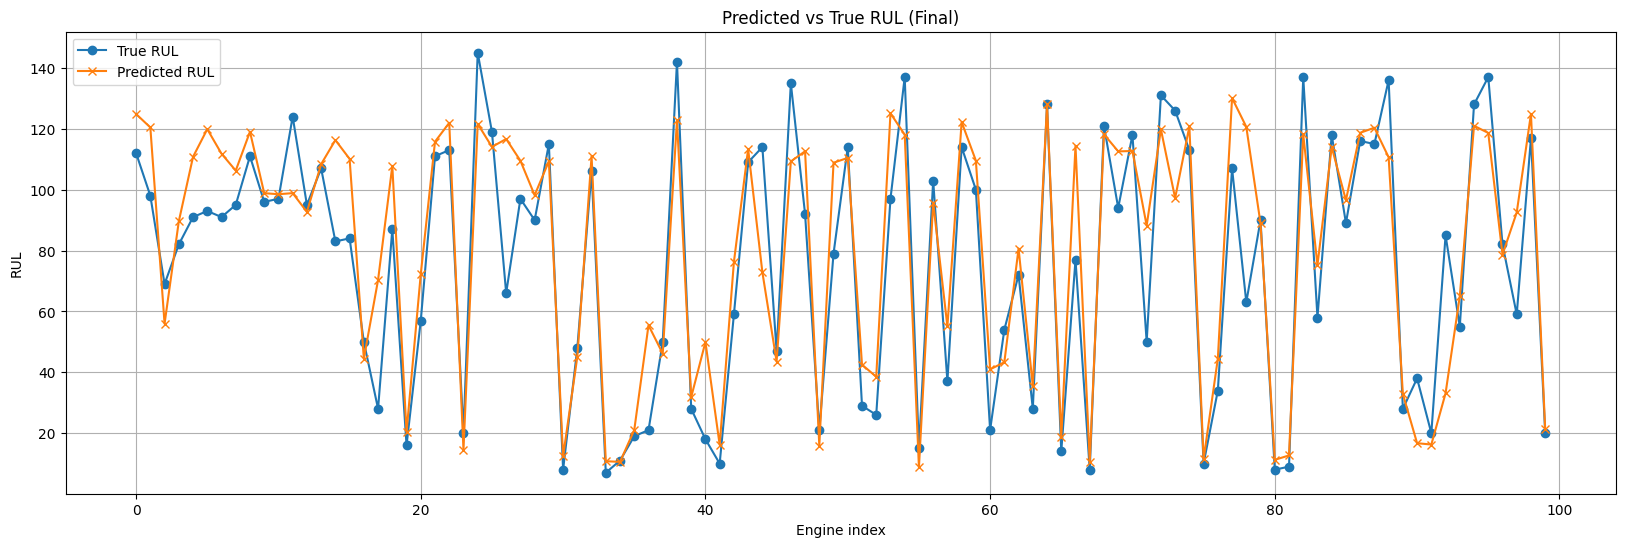

In [173]:

plt.figure(figsize=(20, 6)) 
plt.plot(rul_df.values, label="True RUL", marker='o')
plt.plot(test_pred, label="Predicted RUL", marker='x')
plt.xlabel("Engine index")
plt.ylabel("RUL")
plt.legend()
plt.title("Predicted vs True RUL (Final)")
plt.grid(True)
plt.show()

# Conclusion
This project successfully developed a machine learning model for predicting the Remaining Useful Life (RUL) of aircraft engines using time-series sensor data.

Initial data analysis and cleaning removed uninformative features. Key to improving performance was Feature Engineering, particularly the creation of rolling statistics and lagged features, which significantly boosted the model's accuracy by capturing temporal degradation patterns.

After comparing several baseline models, the CatBoost Regressor, trained with these engineered features, was selected as the final model.

The final evaluation on the unseen test dataset demonstrated that the developed model can effectively predict RUL on new data, highlighting its potential for practical application in predictive maintenance.